In [5]:
print("retest")

# FOLD = '/content/'
FOLD = '/kaggle/working/'
import os


retest


In [6]:
import shutil

# Function to remove a folder and its contents
def remove_folder(path):
    try:
        shutil.rmtree(path)
        print(f"Folder {path} and its contents successfully removed.")
    except OSError as e:
        print(f"Error: {e.strerror}")

# Specify the path of the folder to be removed
folder_path = FOLD + '/dataset'

# Call the function to remove the folder
remove_folder(folder_path)


Error: No such file or directory


In [3]:
!git clone 'https://github.com/QuanHoangNgoc/Figshare_Dataset' dataset


Cloning into 'dataset'...
fatal: unable to access 'https://github.com/QuanHoangNgoc/Figshare_Dataset/': Could not resolve host: github.com


In [6]:
!pwd

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


/kaggle/working


In [7]:
DIR = '/kaggle/input/'
print(DIR)
os.listdir(DIR)


/kaggle/input/


['no', 'yes', 'Br35H-Mask-RCNN', 'pred']

# Source Code

In [8]:
######################################################################################
# Const
######################################################################################
CLEAR_LOG = True  # clear file log (if need)
example_code = True


TYPE = 'COLOR'
SIZE = (240, 240)
VALUE = [0, 255]


In [9]:
######################################################################################
# Set Up
######################################################################################
import skimage as ski
import keras
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
# import Const
import math

if (example_code):
    print("ski version: ", ski.__version__)
    print("keras version: ", keras.__version__)
    print("numpy version: ", np.__version__)
    print("pandas version: ", pd.__version__)
    print("sklearn version: ", skl.__version__)


ski version:  0.22.0
keras version:  3.3.3
numpy version:  1.26.4
pandas version:  2.2.2
sklearn version:  1.2.2


In [10]:
######################################################################################
# Utils
######################################################################################
import logging
from absl import logging as absl_logging
from skimage import io, exposure
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
# from SetUp import *
import inspect


######################################################################################################
# NORMAL UTIL
######################################################################################################
def get_current_method_name(index=2):
    current_frame = inspect.stack()[index]
    method_name = current_frame.function
    return "<" + method_name + ">"


NUM_PRT_SC = int(1e18)


def setup_logging():
    # Set the log file path
    _log_file = os.path.join(os.getcwd(), '_log')
    if not os.path.exists(_log_file):
        os.makedirs(_log_file)
    _log_file = os.path.join(_log_file, 'log.txt')
    if (CLEAR_LOG and os.path.exists(_log_file)):
        os.remove(_log_file)

    # format = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
    # Configure the Python logging to write to the log file
    logging.basicConfig(filename=_log_file, level=logging.INFO, format=None)
    # Redirect absl logging to the Python logging
    absl_logging.use_python_logging()
    absl_logging.info("\n\n")


setup_logging()


class ut:
    _active = True

    def __init__(self):
        pass

    def act(active):
        ut._active = active
        global NUM_PRT_SC
        if NUM_PRT_SC > 2:
            NUM_PRT_SC = 2
        else:
            NUM_PRT_SC = int(1e18)

    def prt_section():
        global NUM_PRT_SC
        if NUM_PRT_SC < 1:
            return
        else:
            NUM_PRT_SC -= 1
        logging.info("~" * int(77 * 1))
        print("~" * int(77 * 1), flush=True)

    def mess(*mess):
        if ut._active == False:
            return
        ut.prt_section()
        out = '# '
        func_dir = get_current_method_name()
        if (func_dir not in ['<over>', '<note_verbose>']):
            out += get_current_method_name() + "\n"

        for arg in mess:
            out += str(arg) + " "
        global absl_logging
        absl_logging.info(out)
        print(out, flush=True)
        ut.prt_section()

    def note_verbose(flag, title):
        if ut._active == False:
            return
        func_dir = get_current_method_name()
        # ut.prt_section()
        ut.mess("__verbose__:", func_dir, "\n", "@@@", title)
        # ut.prt_section()

    def over(val, var_name=None):
        if ut._active == False:
            return
        if var_name == None:
            var_name = "{}".format(get_current_method_name())
        else:
            var_name = "{1} \n [{0}]".format(var_name,
                                             get_current_method_name())
        # ut.prt_section()
        try:
            ratio = val.std()**2/(val.max()-val.min()) * 100
            ratio = round(ratio, 2)
            ut.mess(
                "__var__:",
                var_name + "\n",
                [(val.dtype, type(val)), val.shape], "\n",
                [(val.min(), val.max()), (val.mean(),
                                          val.std() ** 2, str(ratio) + " %")], "\n",
                [np.sum(np.isnan(val)), str(
                    round(sys.getsizeof(val)/10**6, 2)) + " Mb"],
            )
        except:
            try:
                ut.mess(
                    "__var__:",
                    var_name + "\n",
                    (type(val), len(val), "no-min-max-mean"),
                )
            except:
                ut.mess(
                    "__var__:",
                    var_name + "\n",
                    (type(val), "no-shape", "no-min-max-mean"),
                )
        # ut.prt_section()

    def error(tilte):
        func_dir = get_current_method_name()
        # ut.prt_section()
        ut.mess("__error__:", func_dir, "@@@", tilte)
        # ut.prt_section()
        assert 1 == 0


In [11]:
######################################################################################################
# SKI UTIL
######################################################################################################
def retype_image(image: np.ndarray, istype: str):
    if (istype not in ['float', 'ubyte', 'int']):
        ut.error()
    if (istype == 'float'):
        return ski.util.img_as_float(image)
    if (istype == 'ubyte'):
        return ski.util.img_as_ubyte(image)
    if (istype == 'int'):
        return ski.util.img_as_int(image)
    ut.error()


def revalue_image(image, in_range, out_range):
    return ski.exposure.rescale_intensity(image, in_range=in_range, out_range=out_range)


def show_image(image: np.ndarray, choose=1):
    try:
        assert (choose == 0)
        out = ski.util.img_as_uint(image) # Convert to int
        plt.imshow(out)
        plt.axis('off')  # Optional: to hide the axis
        plt.show()
    except:
        # Display the image using skimage's viewer
        out = ski.util.img_as_uint(image) # Convert to int
        print('cmap = gray')
        plt.imshow(out, cmap='gray')
        plt.axis('off')  # Optional: to hide the axis
        plt.show()


def read_image(path: str, as_gray=True):
    image = ski.io.imread(path, as_gray=as_gray)
    image = ski.img_as_float(image)
    return image

def recolor_image(image, channel):
    if (channel not in ['gray', 'rgb']):
        ut.error()
    if (channel == 'gray'):
        return ski.color.rgb2gray(image)
    if (channel == 'rgb'):
        return ski.color.gray2rgb(image)
    ut.error()


def show_his(image):
    try:
        colors = ('red', 'green', 'blue')
        for color, channel in zip(colors, image.transpose((2, 0, 1))):
            hist, hist_centers = exposure.histogram(channel)
#             hist /= len(hist.flatten())
            plt.fill_between(hist_centers, hist, label=color, alpha=0.3)
        plt.legend()
        plt.title('Histogram for Each Color Channel')
    except:
        # Compute the histogram
        hist, hist_centers = exposure.histogram(image)
#         hist /= len(hist.flatten())
        # Display the histogram
        plt.fill_between(hist_centers, hist, alpha=0.3)
        plt.title('Histogram of Grayscale Image')
    plt.xlabel('Pixel intensity')
    plt.ylabel('Frequency')
    plt.show()


In [12]:
######################################################################################################
# Random files
######################################################################################################
import random
def get_random_file_in_folder(root_folder, K):
    lis = []
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            file_path = os.path.join(root, file)
            lis.append(file_path)
    random.shuffle(lis)
    return lis[:K]


# Abstraction 

In [13]:
import json 
from collections import defaultdict 


with open(DIR + '/Br35H-Mask-RCNN/annotations_all.json', 'r') as file:
    # Load the JSON data from the file
    jfile = json.load(file)
    
    
loc_datadict = defaultdict(list)
print("len of jfile: ", len(jfile))
for key_row in jfile.keys():
    dic = jfile[key_row]
    filename = dic["filename"]
    regions = dic["regions"]
    if(len(regions) > 1): 
#         print(filename + ' next!', end=' ')
        continue
    else: 
        region = regions[0]
    if(region["shape_attributes"]["name"] != "polygon"): continue 
    x_list = region["shape_attributes"]["all_points_x"]
    y_list = region["shape_attributes"]["all_points_y"]
    loc_datadict[filename] = (x_list, y_list)

print()
print("len of loc_datadict: ", len(loc_datadict))


len of jfile:  801

len of loc_datadict:  527


In [14]:
yes_list = list(loc_datadict.keys())
yes_list = sorted(yes_list) 
no_list = os.listdir(DIR + '/no')
no_list = sorted(no_list) 


print(len(yes_list), len(no_list))
# print(yes_list)
# print(no_list)


527 1500


## --Create Data

In [15]:
import cv2
from sklearn.model_selection import train_test_split


def create_class_data(num_few=32, seed=42, show_image=False): 
    def get(filename_list, name, label): 
        X, Y = [], []  
        for filename in filename_list: 
            path = os.path.join(DIR, name, filename) 
#             print(path, end=' ')
            org_image = io.imread(path) # x3 
            org_image = retype_image(org_image, 'ubyte') # ubyte 
            
            org_image = ski.transform.resize(org_image, (240, 240, 3), anti_aliasing=True) # Resize -> Retype
            org_image = retype_image(org_image, 'ubyte') # Retype/Revalue
            assert(org_image.all() >= 0 and org_image.all() <= 255) 

            X.append(org_image)
            Y.append(label) 
        X, Y = np.array(X), np.array(Y)
        _, X, _, Y = train_test_split(X, Y, test_size=num_few, random_state=seed)
        return X, Y 

    X0, Y0 = get(no_list, "no", 0)
    X1, Y1 = get(yes_list, "yes", 1)
    X, Y = np.concatenate((X0, X1), axis=0), np.concatenate((Y0, Y1), axis=0)
    return X, Y


In [16]:
X, Y = create_class_data()

ut.over(X, "X")
ut.over(Y, "Y")


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [X]
 [(dtype('uint8'), <class 'numpy.ndarray'>), (64, 240, 240, 3)] 
 [(0, 255), (71.35280318648726, 5529.057031014749, '2168.26 %')] 
 [0, '11.06 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [Y]
 [(dtype('int64'), <class 'numpy.ndarray'>), (64,)] 
 [(0, 1), (0.5, 0.25, '25.0 %')] 
 [0, '0.0 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


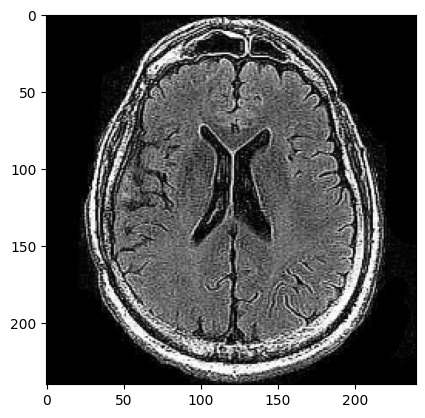

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# <<module>>
31 0 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [17]:
if(example_code): 
    id = np.random.randint(len(X))
    image = X[id]
    label = Y[id]
    plt.imshow(image)
    plt.show()
    ut.mess(id, label)


# Class Game 

In [42]:
import torch 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class ClassGame: 
    def __init__(self, state_size, action_size, X, Y, iter, K, X_test=None, Y_test=None): 
        self.state_size = state_size
        self.action_size = action_size
        self.X, self.Y = X, Y
        self.iter, self.K = iter, K 
        self.X_test, self.Y_test = X_test, Y_test
        self.Q = 5 

    def get_action_size(self): return self.action_size
    def get_state_size(self): return self.state_size

    def get_current(self): 
        id = self.order_list[self.cur]
        return self.X[id], self.Y[id]

    def reset(self): 
        idx = defaultdict(list)
        for i in range(len(self.Y)): 
            idx[Y[i]].append(i) 
        
        self.order_list = [] 
        action_list = [a for a in range(self.action_size)]
        for _ in range(self.iter): 
            lis = [] 
            random.shuffle(action_list)
            for a in action_list: 
                random_elements = np.random.choice(idx[a], size=self.K, replace=False) # False 
                lis.extend(random_elements)
#             random.shuffle(lis)
            new = [] # xQ 
            for x in lis: new.extend([x] * self.Q)
            self.order_list.extend(new)

        self.cur = 0 
        self.his_train = []
        self.his_test = [] 
        return self.get_current() 
    
    def step(self, action): 
        x, y = self.get_current() 
        self.cur += 1 
        done = False 
        if(self.cur % self.Q == 0): done = True 
        if(y == action): 
            return +1.0, done 
        return -1.0, done 

    def test(self, model): 
        def unit_test(X_test, Y_test): 
            states = torch.FloatTensor(X_test).to(device)
            actions = model(states).argmax(dim=1)
            # Convert y_test to PyTorch tensor for comparison
            y_test_tensor = torch.tensor(Y_test).to(device)
            # Calculate accuracy
            correct_predictions = torch.sum(actions == y_test_tensor).item()
            total_samples = len(actions)
            ut.mess("acc:", correct_predictions, "/", total_samples)
            return correct_predictions
        
        self.his_train.append(unit_test(self.X, self.Y))
        self.his_test.append(unit_test(self.X_test, self.Y_test))


In [44]:
env = ClassGame((3, 240, 240), 2, X, Y, 100, 32)
x, y = env.reset()
# env.order_list


# Agent

In [45]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque, defaultdict 


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is: ", device)


class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        
        # Convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ELU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ELU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ELU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ELU()
        )

        # Dense layers
        self.dense_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*15*15, 512), # 240 / 2 / 2 / 2 / 2
            nn.ELU(),
            nn.Linear(512, 256),
            nn.ELU(),
            nn.Linear(256, 128),
            nn.ELU(),
            nn.Linear(128, action_size)
        )
        
        # Initialize the weights using Glorot uniform initialization
        for layer in self.modules():
            if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.dense_layers(x)
        return x
    

Device is:  cuda


In [46]:
class Agent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size

        self.batch_size = 16 # extract mem 
        memory_step = int(5000) # max mem
        self.memory = defaultdict(deque) # will change      
        for a in range(self.action_size): 
            self.memory[a] = deque(maxlen=memory_step)
        self.slow_step = int(100) # min mem 
        self.target_step = int(50) 


        self.gamma = 0.99
        self.epsilon = 0.7 # will change 
        self.epsilon_min = 1e-4
        self.num_step_decay = int(7000) # 1e-4 
        self.epsilon_decay = (self.epsilon - self.epsilon_min) / self.num_step_decay
        self.lr = 1e-4 


        self.model = DQN(state_size, action_size).to(device)
        self.target_model = DQN(state_size, action_size).to(device)
        self.target_model.load_state_dict(self.model.state_dict())
        self.target_model.eval()

        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.fnloss = nn.MSELoss()


    def memorize(self, state, action, reward, next_state, done):
        self.memory[action].append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.uniform(0, 1) <= self.epsilon:
            return random.randrange(self.action_size)
        with torch.no_grad():
            tensor4D = torch.FloatTensor(state).unsqueeze(0).to(device) # 3d -> 4d 
            q_values = self.model(tensor4D)
            return torch.argmax(q_values).item()

        
    def tolist(self, lis): 
        for i in range(len(lis)): lis[i] = lis[i].tolist()
        return lis
    def tonp(self, lis): 
        for i in range(len(lis)): lis[i] = np.array(lis[i])
        return lis 
    
    def experience_replay(self):
        sum_states, sum_actions, sum_rewards, sum_next_states, sum_dones = [], [], [], [], []
        for a in range(self.action_size): 
            if(len(self.memory[a]) < self.slow_step): 
                self.slow = True 
                return 

            self.slow = False 
            mini_batch = random.sample(self.memory[a], self.batch_size)
            states, actions, rewards, next_states, dones = zip(*mini_batch) # tuple 
#             tmp = [states, actions, rewards, next_states, dones]
#             states, actions, rewards, next_states, dones = self.tolist(tmp) # list

            sum_states.extend(states) # extend a list 
            sum_actions.extend(actions)
            sum_rewards.extend(rewards)
            sum_next_states.extend(next_states)
            sum_dones.extend(dones)
        states, actions, rewards, next_states, dones = sum_states, sum_actions, sum_rewards, sum_next_states, sum_dones
        tmp = [states, actions, rewards, next_states, dones]
        states, actions, rewards, next_states, dones = self.tonp(tmp) # numpy 
        
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).view(-1, 1).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.BoolTensor(dones).to(device)


        next_q_values = self.target_model(next_states).max(dim=1)[0].detach()
        target_q_values = rewards + self.gamma * (1 - dones.float()) * next_q_values

        q_values = self.model(states)
        q_values_actions = q_values.gather(1, actions)

        loss = self.fnloss(q_values_actions, target_q_values.unsqueeze(1))

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon - self.epsilon_decay)


# Class Training

In [47]:
X, Y = create_class_data(500)
X_test, X, Y_test, Y = train_test_split(X, Y, test_size=100, random_state=42)
_, X_test, _, Y_test = train_test_split(X_test, Y_test, test_size=500, random_state=42)


ut.over(X, "X")
ut.over(Y, "Y")
ut.over(X_test, "X_test")
ut.over(Y_test, "Y_test")


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [X]
 [(dtype('uint8'), <class 'numpy.ndarray'>), (100, 240, 240, 3)] 
 [(0, 255), (75.3891537037037, 5607.856106964344, '2199.16 %')] 
 [0, '17.28 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [Y]
 [(dtype('int64'), <class 'numpy.ndarray'>), (100,)] 
 [(0, 1), (0.52, 0.24959999999999993, '24.96 %')] 
 [0, '0.0 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [X_test]
 [(dtype('uint8'), <class 'numpy.ndarray'>), (500, 240, 240, 3)] 
 [(0, 255), (78.05017104166667, 5778.173401593422, '2265.95 %')] 
 [0, '86.4 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~

In [48]:
X = np.transpose(X, (0, 3, 1, 2))
X_test = np.transpose(X_test, (0, 3, 1, 2))

ut.over(X, "X")
ut.over(Y, "Y")
ut.over(X_test, "X_test")
ut.over(Y_test, "Y_test")


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [X]
 [(dtype('uint8'), <class 'numpy.ndarray'>), (100, 3, 240, 240)] 
 [(0, 255), (75.3891537037037, 5607.856106964344, '2199.16 %')] 
 [0, '0.0 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [Y]
 [(dtype('int64'), <class 'numpy.ndarray'>), (100,)] 
 [(0, 1), (0.52, 0.24959999999999993, '24.96 %')] 
 [0, '0.0 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [X_test]
 [(dtype('uint8'), <class 'numpy.ndarray'>), (500, 3, 240, 240)] 
 [(0, 255), (78.05017104166667, 5778.173401593422, '2265.95 %')] 
 [0, '0.0 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [49]:
print(np.sum(Y_test == 0), np.sum(Y_test == 1))
print(np.sum(Y == 0), np.sum(Y == 1))


243 257
48 52


In [51]:
X =  X.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

ut.over(X, "X")
ut.over(Y, "Y")
ut.over(X_test, "X_test")
ut.over(Y_test, "Y_test")


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [X]
 [(dtype('float32'), <class 'numpy.ndarray'>), (100, 3, 240, 240)] 
 [(0.0, 0.003921569), (0.0011593885, 1.3262823922428028e-06, '0.03 %')] 
 [0, '69.12 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [Y]
 [(dtype('int64'), <class 'numpy.ndarray'>), (100,)] 
 [(0, 1), (0.52, 0.24959999999999993, '24.96 %')] 
 [0, '0.0 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [X_test]
 [(dtype('float32'), <class 'numpy.ndarray'>), (500, 3, 240, 240)] 
 [(0.0, 0.003921569), (0.0012003129, 1.3665649362427923e-06, '0.03 %')] 
 [0, '345.6 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~

In [36]:
def class_train(X, Y, X_test, Y_test): 
    action_size = 2 
    state_size = X[0].shape
    agent = Agent(state_size=state_size, action_size=action_size)
    env = ClassGame(state_size, action_size, X, Y, 100, 32, X_test, Y_test)

    
    ut.mess(state_size, action_size)
    ut.over(X, "X")
    ut.over(Y, "Y")
    ut.over(X_test, "X_test")
    ut.over(Y_test, "Y_test")

    env.reset() 
    num_steps = int(10000)
    ut.mess(len(env.order_list))
    assert(len(env.order_list) >= num_steps)
    
    
    for istep in range(num_steps):
        x, y = env.get_current() 
        action = agent.act(x)
        reward, done = env.step(action)

        agent.memorize(x, action, reward, x, False)
        agent.experience_replay()
        agent.decay_epsilon()
        if (istep+1) % agent.target_step == 0:
            agent.update_target_model()

        # evaluate 
        if (istep+1) % (50) == 0: 
            ut.mess("istep: ", istep+1)
            if(agent.slow): 
                ut.mess("agent slow!")
                for a in range(agent.action_size): 
                    ut.mess(a, len(agent.memory[a]))
            env.test(agent.model)

    return agent, env


In [52]:
agent, env = class_train(X, Y, X_test, Y_test)


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# <class_train>
(3, 240, 240) 2 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <class_train> 
 [X]
 [(dtype('float32'), <class 'numpy.ndarray'>), (100, 3, 240, 240)] 
 [(0.0, 0.003921569), (0.0011593885, 1.3262823922428028e-06, '0.03 %')] 
 [0, '69.12 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <class_train> 
 [Y]
 [(dtype('int64'), <class 'numpy.ndarray'>), (100,)] 
 [(0, 1), (0.52, 0.24959999999999993, '24.96 %')] 
 [0, '0.0 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <class_train> 
 [X_test]
 [(dtype('float32'), <class 'numpy.ndarray'

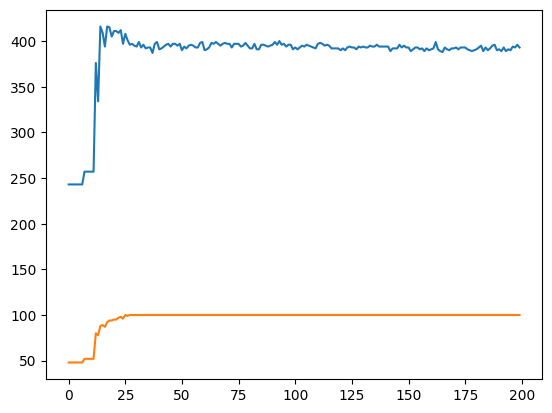

In [53]:
for i in range(len(Y)): 
    if(agent.act(X[i]) != Y[i]): ut.mess(i, Y[i])
        
plt.plot(env.his_test)
plt.plot(env.his_train)
